In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.io as io
import scipy.signal as signal
import scipy.fft as fft

In [3]:
mpl.rcParams['xtick.labelsize'] = 20;
mpl.rcParams['ytick.labelsize'] = 20;
mpl.rcParams['axes.titlesize'] = 25;
plt.rc('axes', labelsize=22.5);
mpl.rcParams['font.family'] = 'sans-serif'
sapin = (0.15, 0.39, 0.10)

## Pure chirp

A chirp is defined as a ` transient waveform modulated in both amplitude and frequency.'   
(P. Flandrin, *Explorations in time-frequency analysis*)

$$
x(t; t_0, d, A) = A(t_0 - t)^{-1/4} \cos(2 \pi d (t_0-t)^{5/8} + \varphi) \boldsymbol{1}_{(-\infty, t_0[}(t)
$$

with **instantaneous** amplitude $a(t) = A(t_0 - t)^{-1/4}$ and frequency $\displaystyle
\omega(t) = 2 \pi \frac{\mathrm{d}}{\mathrm{d}t} \left(d (t_0-t)^{5/8}\right)
$

Text(0, 0.5, 'x [a.u.]')

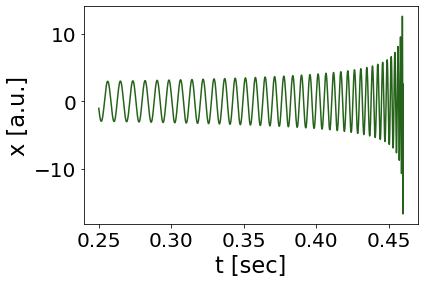

In [4]:
# Time slot
N      = 3441
dt     = 6.10e-5
time   = 0.25 + dt*np.arange(N)

# Parameters of the waveform
t0     = time[-1]+dt
A      = 2
d      = 100
phi    = 0

# Build the chirp
x      = A*(t0-time)**(-1/4)*np.cos(2*np.pi*d*(t0-time)**(5/8)+phi) 

# Display
plt.plot(time,x,color= sapin)
plt.xlabel('t [sec]')
plt.ylabel('x [a.u.]')

## Pure noise

Text(0, 0.5, 'n [a.u.]')

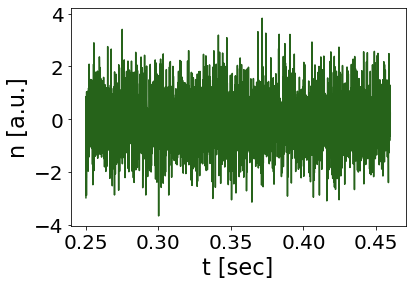

In [5]:
# Length of the signal
N = time.shape[0]

# Generate white Gaussian noise
noise = np.random.randn(N)

plt.plot(time,noise,color= sapin)
plt.xlabel('t [sec]')
plt.ylabel('n [a.u.]')

## Synthetic noisy observations

The standard model of signal processing is the *additive independent noise model* in which one measures
$$
y(t) = x(t) + \frac{1}{\mathrm{SNR}} n(t)
$$
where $x$ is the clean signal, $n$ is some normalized noise independent of $x$ and $\mathrm{SNR}$ is the signal-to-noise ratio.

Text(0, 0.5, 'y [a.u.]')

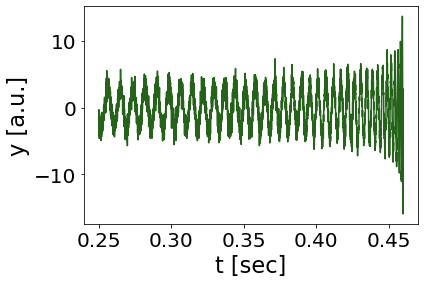

In [6]:
snr = 1
y   = x + 1/snr*noise

plt.plot(time,y,color=sapin)
plt.xlabel('t [sec]')
plt.ylabel('y [a.u.]')

## Fourier analysis

The frequency content of a signal is computed from its Fourier transform defined as

$$
\mathcal{F}x(\omega) = \int_{\mathbb{R}} \overline{x(t)} \exp(-\mathrm{i}\omega t)\, \mathrm{d}t.
$$

Text(0, 0.5, '| Fy | [a.u.]')

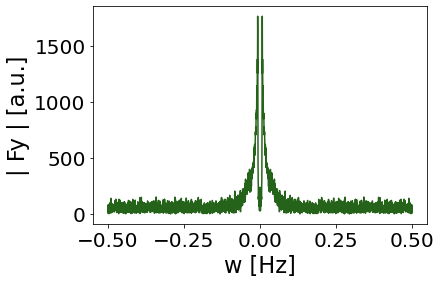

In [7]:
# Fourier analysis
Fy        = fft.fft(y)
freq      = fft.fftfreq(N)

# Remap the frequencies
Fy        = fft.fftshift(Fy)
freq      = fft.fftshift(freq)


plt.plot(freq,np.abs(Fy),color=sapin)
plt.xlabel('w [Hz]')
plt.ylabel('| Fy | [a.u.]')

## Time-frequency analysis

In [ ]:
# Gaussian window of unit energy
g        = signal.gaussian(N, np.sqrt((N)/2/np.pi))
g        = g/g.sum()

# Compute the Gaussian Short-Time Fourier Transform
f, t, Zx = signal.stft(x, fs = 1/dt, window=g, nperseg=N, noverlap=N-1)

# Cut the interesting part
f_int    = f[0:500]
Zx_int   = Zx[0:500,:]

# Display the spectrogram magnitude
plt.pcolormesh(time, f_int, np.abs(Zx_int), shading='gouraud', cmap = 'PiYG')
plt.title('STFT Magnitude')
plt.ylabel('w [Hz]')
plt.xlabel('t [sec]')

Text(0.5, 0, 't [sec]')

In [ ]:
# Complex noise 
cnoise    = (np.random.randn(N)+1j*np.random.randn(N))/np.sqrt(2)
cy        = x + 1/snr*cnoise 

# Compute the Gaussian Short-Time Fourier Transform
f, t, Zcy = signal.stft(cy, fs = 1/dt, window=g, nperseg=N, noverlap=N-1, return_onesided=False)

# Cut the interesting part
f_int     = f[0:500]
Zcy_int   = Zcy[0:500,:]

# Display the spectrogram magnitude
plt.pcolormesh(time, f_int, np.abs(Zcy_int), shading='gouraud', cmap = 'PiYG')
plt.title('STFT Magnitude')
plt.ylabel('w [Hz]')
plt.xlabel('t [sec]')

## Signal processing in the time-frequency plane

In [ ]:
# Thresholding of the spectrogram
th         = 0.35        # choose a percentage of the max
Scy        = np.abs(Zcy) # magnitude of the STFT
mask       = Scy >= th*Scy.max() 
mask       = mask.astype(float)
Zcy_th     = Zcy*mask

Zcy_int_th = Zcy_th[0:500,:]

# Display the threshold spectrogram magnitude
plt.pcolormesh(time, f_int, np.abs(Zcy_int_th), shading='gouraud', cmap = 'PiYG')
plt.title('STFT Magnitude')
plt.ylabel('w [Hz]')
plt.xlabel('t [sec]')

In [ ]:
# Inverse Shirt-Time Fourier Transform
_, Rcy = signal.istft(Zcy, fs = 1/dt, window=g, nperseg=N, noverlap=N-1, input_onesided = False)

# Display the reconstructed signal
plt.plot(time, Rcy.real, color=(0.15, 0.39, 0.10))
plt.ylabel('x [a.u.]')
plt.xlabel('t [sec]')

In [ ]:
def extr2min(M):
    central = M[1:-1, 1:-1]
    mask = np.full(central.shape, True, dtype=bool)
    sub_indices = (
        (np.s_[2:], np.s_[1:-1]),
        (np.s_[:-2], np.s_[1:-1]),
        (np.s_[1:-1], np.s_[2:]),
        (np.s_[1:-1], np.s_[:-2]),
        (np.s_[:-2], np.s_[:-2]),
        (np.s_[:-2], np.s_[2:]),
        (np.s_[2:], np.s_[2:]),
        (np.s_[2:], np.s_[:-2]),
    )
    for I, J in sub_indices:
        np.logical_and(mask, central <= M[I, J], out=mask, where=mask)

    x, y = np.where(mask)
    return x + 1, y + 1

In [ ]:
# Find the zeros
zx, zy    = extr2min(np.abs(Zcy_int))

# Display the spectrogram and its zeros
plt.pcolormesh(time, f_int, np.abs(Zcy_int), shading='gouraud', cmap = 'PiYG')
plt.scatter(time[zy],f_int[zx],s = 15,color = 'mistyrose')
plt.title('STFT Magnitude')
plt.ylabel('w [Hz]')
plt.xlabel('t [sec]')